In [1]:
%load_ext autoreload
%autoreload 3
import pickle
import discovery as ds
import glob
import numpy as np
import json
import jax
import numpyro
import matplotlib.pyplot as plt
import jax.numpy as jnp
import ipta_dr3_functions as dr3
import numpyro.distributions as dist
import numpyro.infer as infer

In [2]:
# load pulsars from feather location. convention is to sort these, to keep
# ordering the same in general.

# If you have a pulsar pickle with a list of enterprise pulsars you can 
# create feather files by running: `dr3.pickle_to_feather(psr_pickle, output_feather_directory, tag='ipta_edr3')`
# and it will load the pickle and create feather files for each pulsar here: f'{output_feather_directory}/{psr.name}_{tag}.feather'

psrs = [ds.Pulsar.read_feather(f) for f in sorted(glob.glob('edr3_feathers/*_edr3_t2.feather'))][:3] # only 3 pulsars for now

In [3]:
# get pulsar names
pulsar_names = [psr.name for psr in psrs]

In [4]:
# load white noise dict, fix negative infinities
wn_dict = dr3.load_wn_dict('TN_wn_dict_enterprise_compatible.json')

In [5]:
# create curn and numpyro model
curn_numpyro_model = dr3.create_ipta_curn_numpyro_model(psrs, wn_dict,
                                                        num_red_noise_frequencies=30,
                                                        num_dmgp_frequencies=100,
                                                        num_curn_frequencies=8)

In [6]:
# set up numpyro NUTS sampling, fewer samples, smaller tree depth 
# for finding new sample so this doesn't run forever on CPU. 
kernel_curn = infer.NUTS(curn_numpyro_model, max_tree_depth=6)
sampler_curn = infer.MCMC(kernel_curn, num_samples=100, num_warmup=100)

In [ ]:
# run sampler. 
# may take a while for first sample because numpyro has to compile the jax code.
sampler_curn.run(jax.random.PRNGKey(123))

sample:  74%|███████▍  | 148/200 [01:05<00:21,  2.45it/s, 63 steps of size 1.22e-01. acc. prob=0.65]

In [ ]:
# get samples
samples = sampler_curn.get_samples()

In [ ]:
samples.keys()

dict_keys(['crn_gamma', 'crn_log10_A', 'dmgp_gamma', 'dmgp_log10_A', 'loglike', 'red_noise_gamma', 'red_noise_log10_A'])

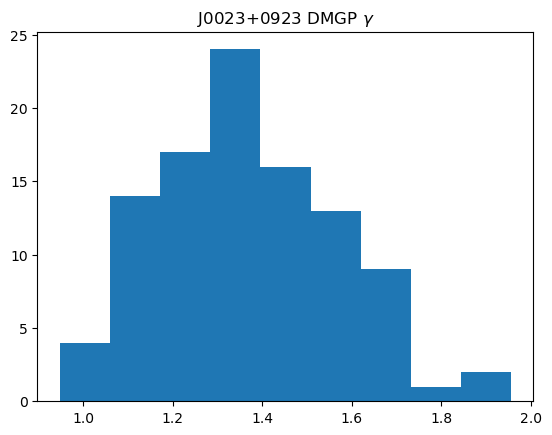

In [ ]:
plt.hist(samples['dmgp_gamma'][:, 0], bins='auto')
plt.title(f"{pulsar_names[0]} DMGP $\gamma$")
plt.show()